# Maximum Mean Discrepancy
(in progress)
## Biased, squared maximum mean discrepancy
Proposed by Gretton et al. (2012)

$MMD_b^2 = \frac{1}{m^2} \sum_{i,j=1}^m k(x_i,x_j)-\frac{2}{mn}\sum_{i,j=1}^{m,n} k(x_i,y_j)+\frac{1}{n^2}\sum_{i,j=1}^n k(y_i,y_j)$
### Kernel choices
#### Energy kernel
Suggested by Feydy et al. (2019), Feydy (2020)

$k(x,y) = -||x-y||$
#### Gaussian kernel
$k(x,y) = \exp\left(-\frac{||x-y||^2}{2\sigma^2}\right)$
whereby
$||x-y||^2 = x^\top x - 2xy + y^\top y$
### Example: MMD with energy kernel
$MMD_b^2 = \frac{1}{m^2} \sum_{i,j=1}^m \underbrace{-||x_i-x_j||}_{A}-\frac{2}{mn}\sum_{i,j=1}^{m,n} \underbrace{-||x_i-y_j||}_{B}+\frac{1}{n^2}\sum_{i,j=1}^n \underbrace{-||y_i-y_j||}_{C}$
consider $x, y$ to be column vectors.

#### Step 1: Compute the euclidean distance
\begin{align*}
\textbf{A :} &-||x_i-x_j||= -\sqrt{ \left(||x_i-x_j||^2 \right)} = -\sqrt{\left( x_i x_i^\top - 2x_i x_j^\top + x_j x_j^\top \right)} \\
\textbf{B :} &-||x_i-y_j||=-\sqrt{\left(||x_i-y_j||^2\right)} = -\sqrt{\left(x_i x_i^\top - 2x_i y_j^\top + y_j y_j^\top\right)} \\
\textbf{C :} &-||y_i-y_j||=-\sqrt{\left(||y_i-y_j||^2\right)} = -\sqrt{\left(y_i y_i^\top - 2y_i y_j^\top + y_j y_j^\top\right)}
\end{align*}

#### Step 2: Compute the biased squared maximum mean discrepancy
$MMD_b^2 = \frac{1}{m^2} \sum_{i,j=1}^m A -\frac{2}{mn}\sum_{i,j=1}^{m,n} B +\frac{1}{n^2}\sum_{i,j=1}^n C$

### References:

+ Feydy, J., Séjourné, T., Vialard, F. X., Amari, S. I., Trouvé, A., & Peyré, G. (2019, April). Interpolating between optimal transport and mmd using sinkhorn divergences. In The 22nd International Conference on Artificial Intelligence and Statistics (pp. 2681-2690). PMLR. [PDF](http://proceedings.mlr.press/v89/feydy19a/feydy19a.pdf)
+ Feydy, J. (2020). Geometric data analysis, beyond convolutions. Applied Mathematics, 3. PhD Thesis. [PDF](https://www.jeanfeydy.com/geometric_data_analysis.pdf)
+ Gretton, A., Borgwardt, K. M., Rasch, M. J., Schölkopf, B., & Smola, A. (2012). A kernel two-sample test. The Journal of Machine Learning Research, 13(1), 723-773. [PDF](https://www.jmlr.org/papers/volume13/gretton12a/gretton12a.pdf?ref=https://githubhelp.com)

## Implementation

In [248]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

class MMD2:
    def __init__(self, kernel : str = "energy", sigma : int or None = None,
                 **kwargs):
        """
        Computes the biased, squared maximum mean discrepancy

        Parameters
        ----------
        kernel : str
            kernel type used for computing the MMD such as "gaussian", "energy"
            The default is "energy".
        sigma : int, optional
            Variance parameter used in the gaussian kernel.
            The default is None.
        **kwargs : keyword arguments
            Additional keyword arguments.

        """
        self.kernel_name = kernel
        self.sigma = sigma

    def __call__(self, x, y):
        """
        Computes the biased, squared maximum mean discrepancy of two samples

        Parameters
        ----------
        x : tensor of shape (batch, num_samples)
            preprocessed expert-elicited statistics.
            Preprocessing refers to broadcasting expert data to same shape as
            model-simulated data.
        y : tensor of shape (batch, num_samples)
            model-simulated statistics corresponding to expert-elicited
            statistics

        Returns
        -------
        MMD2_mean : float
            Average biased, squared maximum mean discrepancy between expert-
            elicited and model simulated data.

        """
        # treat samples as column vectors
        x = tf.expand_dims(x, -1)
        y = tf.expand_dims(y, -1)

        # Step 1
        # compute dot product between samples
        xx = tf.matmul(x, x, transpose_b=True)
        xy = tf.matmul(x, y, transpose_b=True)
        yy = tf.matmul(y, y, transpose_b=True)
        
        # compute squared difference
        u_xx = self.diag(xx)[:,:,None] - 2*xx + self.diag(xx)[:,None,:]
        u_xy = self.diag(xx)[:,:,None] - 2*xy + self.diag(yy)[:,None,:]
        u_yy = self.diag(yy)[:,:,None] - 2*yy + self.diag(yy)[:,None,:]

        # apply kernel function to squared difference
        XX = self.kernel(u_xx, self.kernel_name, self.sigma)
        XY = self.kernel(u_xy, self.kernel_name, self.sigma)
        YY = self.kernel(u_yy, self.kernel_name, self.sigma)

        # Step 2
        # compute biased, squared MMD
        MMD2 = tf.reduce_mean(XX, (1,2)) - 2*tf.reduce_mean(XY, (1,2)) + tf.reduce_mean(YY, (1,2))
        MMD2_mean = tf.reduce_mean(MMD2)

        return MMD2_mean, MMD2, XX, XY, YY

    def clip(self, u):
        u_clipped = tf.clip_by_value(u, clip_value_min=1e-8, 
                                     clip_value_max=int(1e10))
        return u_clipped

    def diag(self, xx):
        diag = tf.experimental.numpy.diagonal(xx, axis1=1, axis2=2)
        return diag

    def kernel(self, u, kernel, sigma):
        if kernel=="energy":
            # clipping for numerical stability reasons
            d=-tf.math.sqrt(self.clip(u))
        if kernel=="gaussian":
            d=tf.exp(-0.5*tf.divide(u, sigma))
        return d

## Example simulations
### Numeric toy example with one-dimensional samples $X\sim N(0,0.05)$ and $Y\sim N(1,0.08)$

In [450]:
# instance of MMD2 class
mmd2 = MMD2(kernel="energy")

# initialize batches (B), number of samples (N,M)
B = 40
N,M = (20,50)

# draw for samples from two normals (x,y)
x = tfd.Normal(loc=0, scale=0.05).sample((B,N))
y = tfd.Normal(loc=1, scale=0.08).sample((B,M))

# compute biased, squared mmd for both samples
mmd_avg, mmd_batch, A, B, C = mmd2(x,y)

# print results
print("Biased, squared MMD (avg.):\n", mmd_avg.numpy())
print(" ")
print("Biased, squared MMD (per batch):\n", tf.stack(mmd_batch).numpy())
print(" ")
print("A (shape): ", A.shape, ", A (mean): ", np.round(tf.reduce_mean(A).numpy(), 2))
print("B (shape): ", B.shape, ", B (mean): ", np.round(tf.reduce_mean(B).numpy(), 2))
print("C (shape): ", C.shape, ", C (mean): ", np.round(tf.reduce_mean(C).numpy(), 2))

Biased, squared MMD (avg.):
 1.8592064
 
Biased, squared MMD (per batch):
 [1.8778989 1.8725448 1.8520763 1.8433806 1.8375555 1.8706871 1.8377426
 1.8460778 1.8356341 1.8626964 1.864194  1.8219937 1.8829894 1.8823482
 1.9019922 1.8328006 1.9002373 1.8837405 1.8773578 1.8063233 1.8772355
 1.818045  1.8549396 1.9211222 1.878836  1.8874218 1.8746109 1.8420508
 1.8514216 1.8765984 1.8030391 1.8502506 1.8581074 1.8660026 1.868265
 1.8145266 1.8823993 1.827515  1.8466772 1.8789287]
 
A (shape):  (40, 20, 20) , A (mean):  -0.05
B (shape):  (40, 20, 50) , B (mean):  -1.0
C (shape):  (40, 50, 50) , C (mean):  -0.09


### Behavior of $MMD^2$ for varying differences between $X$ and $Y$
The loss is zero when X=Y otherwise it increases with stronger dissimilarity between X and Y

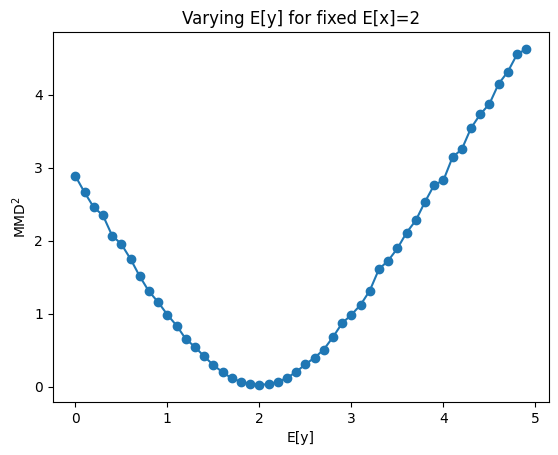

In [498]:
import matplotlib.pyplot as plt

mmd=[]
xrange=tf.range(0, 5, 0.1).numpy()
for m in xrange:
    # instance of MMD2 class
    mmd2 = MMD2(kernel="energy")
    
    # initialize batches (B), number of samples (N,M)
    B = 40
    N,M = (50,50)

    # draw for samples from two normals (x,y)
    x = tfd.Normal(loc=2, scale=0.5).sample((B,N))
    y = tfd.Normal(loc=m, scale=0.5).sample((B,M))
    
    # compute biased, squared mmd for both samples
    mmd_avg, *_ = mmd2(x,y)
    mmd.append(mmd_avg)

plt.plot(xrange, mmd, "-o")
plt.ylabel(r"$MMD^2$")
plt.xlabel("E[y]")
plt.title("Varying E[y] for fixed E[x]=2")
plt.show()

### Behavior of $MMD^2$ for varying scale but same difference between X and Y
Changes in scale do not affect the loss value

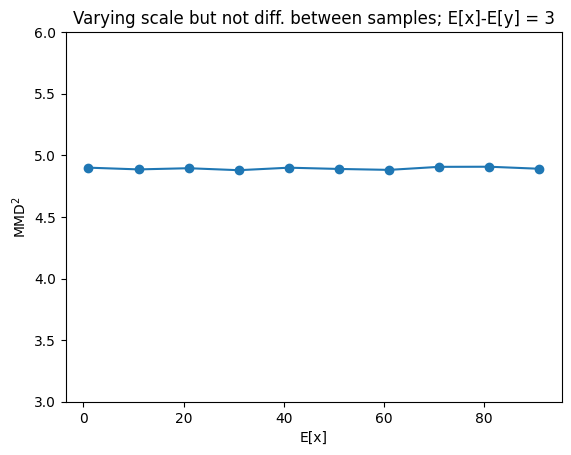

In [491]:
mmd=[]
xrange=tf.range(1.,100., 10).numpy()
for x_m in xrange:
    # instance of MMD2 class
    mmd2 = MMD2(kernel="energy")
    
    # initialize batches (B), number of samples (N,M)
    B = 400
    N,M = (50,50)
    diff = 3.

    # draw for samples from two normals (x,y)
    x = tfd.Normal(loc=x_m, scale=0.5).sample((B,N))
    y = tfd.Normal(loc=float(x_m-diff), scale=0.5).sample((B,M))
    
    # compute biased, squared mmd for both samples
    mmd_avg, *_ = mmd2(x,y)
    mmd.append(mmd_avg)

plt.plot(xrange, mmd, "-o")
plt.ylabel(r"$MMD^2$")
plt.xlabel("E[x]")
plt.title("Varying scale but not diff. between samples; E[x]-E[y] = 3")
plt.ylim(3,6)
plt.show()